In [ ]:
bool_params = ['firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
               'firstRiftHerald']
num_params = ['baronKills', 'riftHeraldKills', 'dragonKills']


In [ ]:
var_diff = ['baronKillsdiff','riftHeraldKillsdiff', 
                   'dragonKillsdiff', 'FIRE_DRAGONdiff', 'EARTH_DRAGONdiff', 
                   'AIR_DRAGONdiff', 'ELDER_DRAGONdiff', 'WATER_DRAGONdiff']
var_team = ['firstTower', 'firstInhibitor',
       'firstDragon', 'firstRiftHerald', 'firstBaron', 'FIRE_DRAGONSoul', 
              'EARTH_DRAGONSoul', 'WATER_DRAGONSoul', 'AIR_DRAGONSoul']
var_firsts = ['firstTower', 'firstInhibitor',
       'firstDragon', 'firstRiftHerald', 'firstBaron']
var_dragtypediff = ['FIRE_DRAGONdiff', 'EARTH_DRAGONdiff', 
                   'AIR_DRAGONdiff', 'ELDER_DRAGONdiff', 'WATER_DRAGONdiff']
var_soul = ['FIRE_DRAGONSoul', 
              'EARTH_DRAGONSoul', 'WATER_DRAGONSoul', 'AIR_DRAGONSoul']

<a id='waiting'></a>
# Running

In [174]:
#pickle/save file
import pickle
with open('data/high_elo_accIds.pkl', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(high_elo_accIds, filehandle)

In [ ]:
#load file
with open('data/high_elo_accIds.pkl', 'rb') as filehandle:
    # read the data as binary data stream
    high_elo_accIds = pickle.load(filehandle)

In [685]:
match_stats_dict2

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'blue',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 1,
  'redriftHeraldKills': 0,
  'blueElemDragNum': 0,
  'blueFIRE_DRAGON': 0,
  'blueEARTH_DRAGON': 0,
  'redElemDragNum': 2,
  'redFIRE_DRAGON': 1,
  'redEARTH_DRAGON': 1,
  '1FIRE_DRAGONteam': 'red',
  '1FIRE_DRAGONtime': 725786,
  '2EARTH_DRAGONteam': 'red',
  '2EARTH_DRAGONtime': 1041620,
  'RIFTHERALD1team': 'blue',
  'RIFTHERALD1time': 587732},
 3435528193: {'GameDuration': 1516,
  'Winner': 'blue',
  'firstTower': 'blue',
  'firstInhibitor': 'red',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 0,
  'redriftHeraldKills': 0},
 3447586821: {'GameDuration': 1964,
  'Winner': 'blue',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstBaron': 'blue',
  'firstDragon': 'red',
  'bluebaronKills': 1,
  'redbaronKills': 0,
  'blueriftH

In [608]:
%%time
for gameId in matchlist[:10000]:
    
    match_detail = match_detail_dict[gameId] #retrieve game details from dict
    match_stats = {} #initialize dict for game
    #create a key for the game winner
    match_stats['GameDuration'] = match_detail['gameDuration']
    if match_detail['teams'][0]['win'] == 'Win':
        match_stats['Winner'] = 'blue' 
    elif match_detail['teams'][1]['win'] == 'Win':
        match_stats['Winner'] = 'red' 

    #store bool params in match details
    for param in bool_params:
        if match_detail['teams'][0][param] == True:
            match_stats[param] = 'blue'
        elif match_detail['teams'][1][param] == True:
            match_stats[param] = 'red'

    #store num params in match details
    for param in num_params:
        match_stats['blue'+param] = match_detail['teams'][0][param]
        match_stats['red'+param] = match_detail['teams'][1][param]


    match_timeline = match_timeline_dict[gameId]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    match_obj_dict[gameId] = match_obj
    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:

            elem_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] != 'ELDER_DRAGON'].dropna(axis=0).reset_index()

            #store total# of drakes on each team, soul dragon info, and # of types of drakes for each team
            for side in ['blue', 'red']:
                match_stats[side+'ElemDragNum'] = elem_drag_df[elem_drag_df['team'] == side].shape[0]
                if match_stats[side+'ElemDragNum'] == 4:
                    match_stats['SoulType'] = elem_drag_df['DragElement'][2]
                    match_stats['SoulTeam'] = side
                for drag_elem in list(elem_drag_df['DragElement'].unique()):
                    match_stats[str(side+drag_elem)] = elem_drag_df.query('DragElement == @drag_elem and team == @side').shape[0]

            #store all details about each drake for the game, including elder
            drag_timeline_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index()
            for row_idx, row in drag_timeline_df.iterrows():
                match_stats['drag'+str(row_idx+1)+'type'] = drag_timeline_df['DragElement'][row_idx]
                match_stats['drag'+str(row_idx+1)+'team'] = drag_timeline_df['team'][row_idx]
                match_stats['drag'+str(row_idx+1)+'time'] = drag_timeline_df['timestamp'][row_idx]

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons killed
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()

                #for each herald/baron, extract the team that killed the objective and the time it occured
                for row_idx, row in obj_type_df.iterrows():
                    match_stats[str(obj_type+str(row_idx+1)+'team')] = obj_type_df['team'][row_idx]
                    match_stats[str(obj_type+str(row_idx+1)+'time')] = obj_type_df['timestamp'][row_idx]
    
    match_stats_dict [gameId] = match_stats

Wall time: 2min 56s


In [ ]:
def extract_match_info(gameId, time):
    '''
    extract post-game match results from match data saved in dict for each match ID
    Returns two dicts (one preinitialized):
    1. parameters for each game:
        - winner (red or blue)
        - red or blue (or neither) for boolean parameters: 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
               'firstRiftHerald'
        - difference between each team for numerical parameters: 'baronKills', 'riftHeraldKills', 'dragonKills'

    2. Extracted information of captured neutral objectives at 5 minute timeframes intervals 
    and saved to preinitialized global dicts. 
    Individual dicts represent each time interval.
    Extracted parameters:
    - Dragons: difference between teams in number of dragons killed for each type of dragon (infernal, ocean, mountain, cloud, elder)
    - type of Dragon soul and the team that captured it
    - Rift herald and baron - difference in numbers of objectives killed between teams
    '''
    #initialize dicts
    match_results_dict = {}
    match_by_time_dict = {}
    
    for gameId in matches:
        if gameId in match_timeline_dict.keys(): #check to make sure that the gameId exists in both API endpoint dicts

            match_detail = match_detail_dict[gameId] #retrieve game details from dict
            match_stats = {} #initialize dict for game

            #extract game length
            match_stats['GameDuration'] = match_detail['gameDuration']
            
            #extract game winner
            if match_detail['teams'][0]['win'] == 'Win':
                match_stats['Winner'] = 'blue' 
            elif match_detail['teams'][1]['win'] == 'Win':
                match_stats['Winner'] = 'red' 

            #store bool params in match details
            for param in bool_params:
                if match_detail['teams'][0][param] == True:
                    match_stats[param] = 'blue'
                elif match_detail['teams'][1][param] == True:
                    match_stats[param] = 'red'

            #store num params in match details
            for param in num_params:
                match_stats[param+'diff'] = match_detail['teams'][0][param] - match_detail['teams'][1][param]
            return match_stats
            
            
            match_by_time = {}
            match_duration = int(match_detail_dict[gameId]['gameDuration']/60)
            t = 10
            while t <= match_duration:
                match_stats = {}
                match_obj = create_obj_list(match_timeline_dict[gameId]['frames'][:time])
                if len(match_obj) > 0:
                    obj_timeline_df = pd.DataFrame(match_obj)
                    if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:
                        #store team+timestamp of any elder dragons
                        drag_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index() #slice df of dragons only
                        
                        for side in ['blue', 'red']: #does either side have soul
                            if drag_df.query('DragElement != "ELDER_DRAGON" and team == @side').shape[0] == 4:
                                match_stats[str(drag_df['DragElement'][2])+'Soulteam'] = side #team with soul
                        for drag_elem in list(drag_df['DragElement'].unique()):
                            match_stats[str(drag_elem)+'diff'] = drag_df.query('DragElement == @drag_elem and team == "blue"').shape[0] - drag_df.query('DragElement == @drag_elem and team == "red"').shape[0]
                
                list_time_dicts[t][gameId] = extract_matchstate_atm(gameId, t)
                t+=5
        match_by_time_dict [gameId] = match_by_time
    
        match_results = extract_match_results(gameId)
        match_results_dict [gameId] = match_results
        
        #add dragon soul from 
        match_results_dict [gameId]
    




    match_stats = {} #initialize dict for game
    match_timeline = match_timeline_dict[gameId]['frames'][:time]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline)):
        for event in match_timeline[i]['events']:
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:

            #store team+timestamp of any elder dragons
            drag_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index() #slice df of dragons only

            for side in ['blue', 'red']: #does either side have soul
                if drag_df.query('DragElement != "ELDER_DRAGON" and team == @side').shape[0] == 4:
                    match_stats[str(drag_df['DragElement'][2])+'Soulteam'] = side #team with soul
            for drag_elem in list(drag_df['DragElement'].unique()):
                match_stats[str(drag_elem)+'diff'] = drag_df.query('DragElement == @drag_elem and team == "blue"').shape[0] - drag_df.query('DragElement == @drag_elem and team == "red"').shape[0]

            #for row_idx, row in elem_drag_df.iterrows():
                #match_stats[str(row_idx+1)+str(row['DragElement'])+'team'] = row['team']

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons kill diff
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:

                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()
                #for each herald/baron, extract the team that killed the objective and the time it occured
                match_stats[str(obj_type)+'diff'] = obj_type_df[obj_type_df['team'] == 'blue'].shape[0] - obj_type_df[obj_type_df['team'] == 'red'].shape[0]
        return match_stats


In [ ]:
%%time
for gameId in matchlist[:20]:
    
    match_detail = match_detail_dict[gameId] #retrieve game details from dict
    match_stats = {} #initialize dict for game
    #create a key for the game winner
    match_stats['GameDuration'] = match_detail['gameDuration']
    if match_detail['teams'][0]['win'] == 'Win':
        match_stats['Winner'] = 'blue' 
    elif match_detail['teams'][1]['win'] == 'Win':
        match_stats['Winner'] = 'red' 

    match_timeline = match_timeline_dict[gameId]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:
            
            #store team+timestamp of any elder dragons
            drag_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index() #slice df of dragons only
            
            for side in ['blue', 'red']: #does either side have soul
                if drag_df.query('DragElement != "ELDER_DRAGON" and team == @side').shape[0] == 4:
                    match_stats[str(drag_df['DragElement'][2])+'Soulteam'] = side #team with soul
            for drag_elem in list(drag_df['DragElement'].unique()):
                match_stats[str(drag_elem)+'diff'] = drag_df.query('DragElement == @drag_elem and team == "blue"').shape[0] - drag_df.query('DragElement == @drag_elem and team == "red"').shape[0]

            #for row_idx, row in elem_drag_df.iterrows():
                #match_stats[str(row_idx+1)+str(row['DragElement'])+'team'] = row['team']

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons kill diff
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
                
                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()
                #for each herald/baron, extract the team that killed the objective and the time it occured
                match_stats[str(obj_type)+'diff'] = obj_type_df[obj_type_df['team'] == 'blue'].shape[0] - obj_type_df[obj_type_df['team'] == 'red'].shape[0]
    
    match_stats_dict [gameId] = match_stats

In [704]:
len(match_stats_dict3)
#3447586821 for a game with elder

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'blue',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 1,
  'redriftHeraldKills': 0,
  'blueElemDragNum': 0,
  'blueFIRE_DRAGON': 0,
  'blueEARTH_DRAGON': 0,
  'redElemDragNum': 2,
  'redFIRE_DRAGON': 1,
  'redEARTH_DRAGON': 1,
  '1FIRE_DRAGONteam': 'red',
  '1FIRE_DRAGONtime': 725786,
  '2EARTH_DRAGONteam': 'red',
  '2EARTH_DRAGONtime': 1041620,
  'RIFTHERALD1team': 'blue',
  'RIFTHERALD1time': 587732},
 3435528193: {'GameDuration': 1516,
  'Winner': 'blue',
  'firstTower': 'blue',
  'firstInhibitor': 'red',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 0,
  'redriftHeraldKills': 0},
 3447586821: {'GameDuration': 1964,
  'Winner': 'blue',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstBaron': 'blue',
  'firstDragon': 'red',
  'bluebaronKills': 1,
  'redbaronKills': 0,
  'blueriftH

In [555]:
match_detail['teams'][0]['firstTower']

False

In [113]:
match_timeline['frames'][17]['events']

[{'type': 'ITEM_PURCHASED',
  'timestamp': 971171,
  'participantId': 7,
  'itemId': 3134},
 {'type': 'ITEM_DESTROYED',
  'timestamp': 971171,
  'participantId': 7,
  'itemId': 1036},
 {'type': 'ITEM_PURCHASED',
  'timestamp': 972360,
  'participantId': 7,
  'itemId': 1036},
 {'type': 'ITEM_PURCHASED',
  'timestamp': 977116,
  'participantId': 7,
  'itemId': 3364},
 {'type': 'ITEM_DESTROYED',
  'timestamp': 977116,
  'participantId': 7,
  'itemId': 3340},
 {'type': 'BUILDING_KILL',
  'timestamp': 985042,
  'position': {'x': 13866, 'y': 4505},
  'killerId': 0,
  'assistingParticipantIds': [],
  'teamId': 200,
  'buildingType': 'TOWER_BUILDING',
  'laneType': 'BOT_LANE',
  'towerType': 'OUTER_TURRET'},
 {'type': 'WARD_PLACED',
  'timestamp': 985570,
  'wardType': 'SIGHT_WARD',
  'creatorId': 9},
 {'type': 'CHAMPION_KILL',
  'timestamp': 986528,
  'position': {'x': 4943, 'y': 8400},
  'killerId': 8,
  'victimId': 4,
  'assistingParticipantIds': [9]},
 {'type': 'ITEM_PURCHASED',
  'timesta

In [79]:
match_timeline = watcher.match.timeline_by_match(my_region, test_gameId)

In [220]:
test_gameId = rand(matchlist)[0]
match_timeline = watcher.match.timeline_by_match(my_region, test_gameId)

watcher.match.by_id
```
'gameId': 3447355549,
 'gameDuration': 1968,
 'gameVersion': '10.11.322.2991',
 
'teams': [{'teamId': 100,
   'win': 'Fail',
   'firstBlood': False,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': True,
   'firstDragon': False,
   'firstRiftHerald': True,
   'towerKills': 4,
   'inhibitorKills': 0,
   'baronKills': 1,
   'dragonKills': 1,
   'vilemawKills': 0,
   'riftHeraldKills': 1,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 154, 'pickTurn': 1},
    {'championId': 89, 'pickTurn': 2},
    {'championId': 38, 'pickTurn': 3},
    {'championId': 53, 'pickTurn': 4},
    {'championId': 17, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Win',
   'firstBlood': True,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': False,
   'firstDragon': True,
   'firstRiftHerald': False,
   'towerKills': 8,
   'inhibitorKills': 2,
   'baronKills': 0,
   'dragonKills': 3,
   'vilemawKills': 0,
   'riftHeraldKills': 0,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 54, 'pickTurn': 6},
    {'championId': 104, 'pickTurn': 7},
    {'championId': 53, 'pickTurn': 8},
    {'championId': 110, 'pickTurn': 9},
    {'championId': 157, 'pickTurn': 10}]}],
```

100 is blue team/bottom side/order
200 is red team/upper side/chaos

1-5 are blue team top to bottom, 6-10 are red team top to bottom in champ select


# [Waiting for process](#waiting)

# [Current workplace](#current)


matchlist, matchlist.txt, matchlist.pkl
match_dict, 'data/match_dict.pkl'
high_elo_accIds

In [19]:
my_ranked_stats = watcher.league.by_summoner(my_region, me['id'])
print(my_ranked_stats)

[{'leagueId': 'c60807e8-6afb-38fd-ab9b-ae8588dc8b27', 'queueType': 'RANKED_SOLO_5x5', 'tier': 'CHALLENGER', 'rank': 'I', 'summonerId': 'KEdqN4fotUa1T0_kMdsRgCRuF925iBfECm9cXnSg5wtIJwM', 'summonerName': 'Doublelift', 'leaguePoints': 722, 'wins': 241, 'losses': 216, 'veteran': True, 'inactive': False, 'freshBlood': False, 'hotStreak': False}]


In [20]:
my_matches = watcher.match.matchlist_by_account(my_region, me['accountId'])

In [ ]:
last_match = my_matches['matches'][0]

In [21]:
# fetch last match detail
last_match = my_matches['matches'][0]
match_detail = watcher.match.by_id(my_region, last_match['gameId'])

participants = []
for row in match_detail['participants']:
    participants_row = {}
    participants_row['champion'] = row['championId']
    participants_row['spell1'] = row['spell1Id']
    participants_row['spell2'] = row['spell2Id']
    participants_row['win'] = row['stats']['win']
    participants_row['kills'] = row['stats']['kills']
    participants_row['deaths'] = row['stats']['deaths']
    participants_row['assists'] = row['stats']['assists']
    participants_row['totalDamageDealt'] = row['stats']['totalDamageDealt']
    participants_row['goldEarned'] = row['stats']['goldEarned']
    participants_row['champLevel'] = row['stats']['champLevel']
    participants_row['totalMinionsKilled'] = row['stats']['totalMinionsKilled']
    participants_row['item0'] = row['stats']['item0']
    participants_row['item1'] = row['stats']['item1']
    participants.append(participants_row)
df = pd.DataFrame(participants)
df

,champion,spell1,spell2,win,kills,deaths,assists,totalDamageDealt,goldEarned,champLevel,totalMinionsKilled,item0,item1
0,64,11,4,False,2,6,6,110000,7474,12,12,1412,2055
1,134,1,4,False,3,5,3,96864,8789,12,158,1056,3285
2,223,14,4,False,1,5,2,20965,5850,10,47,3860,2055
3,62,12,4,False,5,4,4,118651,10550,14,182,3077,0
4,81,4,7,False,0,6,3,87533,7242,12,174,3025,3004
5,142,4,7,True,6,1,7,134740,11396,15,203,2423,3089
6,421,4,11,True,6,1,8,130752,10183,14,22,1412,3047
7,412,4,14,True,1,2,16,20422,7063,12,28,3857,3024
8,429,4,7,True,12,2,5,146010,14333,14,205,1055,3153
9,98,12,4,True,1,5,8,63474,7522,13,128,1054,3748


In [26]:
# check league's latest version
latest = watcher.data_dragon.versions_for_region(my_region)['n']['champion']
# Lets get some champions static information
static_champ_list = watcher.data_dragon.champions(latest, False, 'en_US')

# champ static list data to dict for looking up
champ_dict = {}
for key in static_champ_list['data']:
    row = static_champ_list['data'][key]
    champ_dict[row['key']] = row['id']
for row in participants:
    print(str(row['champion']) + ' ' + champ_dict[str(row['champion'])])
    row['championName'] = champ_dict[str(row['champion'])]

# print dataframe
df = pd.DataFrame(participants)
df

64 LeeSin
134 Syndra
223 TahmKench
62 MonkeyKing
81 Ezreal
142 Zoe
421 RekSai
412 Thresh
429 Kalista
98 Shen


,champion,spell1,spell2,win,kills,deaths,assists,totalDamageDealt,goldEarned,champLevel,totalMinionsKilled,item0,item1,championName
0,64,11,4,False,2,6,6,110000,7474,12,12,1412,2055,LeeSin
1,134,1,4,False,3,5,3,96864,8789,12,158,1056,3285,Syndra
2,223,14,4,False,1,5,2,20965,5850,10,47,3860,2055,TahmKench
3,62,12,4,False,5,4,4,118651,10550,14,182,3077,0,MonkeyKing
4,81,4,7,False,0,6,3,87533,7242,12,174,3025,3004,Ezreal
5,142,4,7,True,6,1,7,134740,11396,15,203,2423,3089,Zoe
6,421,4,11,True,6,1,8,130752,10183,14,22,1412,3047,RekSai
7,412,4,14,True,1,2,16,20422,7063,12,28,3857,3024,Thresh
8,429,4,7,True,12,2,5,146010,14333,14,205,1055,3153,Kalista
9,98,12,4,True,1,5,8,63474,7522,13,128,1054,3748,Shen


watcher.match.by_id
```
'gameId': 3447355549,
 'gameDuration': 1968,
 'gameVersion': '10.11.322.2991',
 
'teams': [{'teamId': 100,
   'win': 'Fail',
   'firstBlood': False,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': True,
   'firstDragon': False,
   'firstRiftHerald': True,
   'towerKills': 4,
   'inhibitorKills': 0,
   'baronKills': 1,
   'dragonKills': 1,
   'vilemawKills': 0,
   'riftHeraldKills': 1,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 154, 'pickTurn': 1},
    {'championId': 89, 'pickTurn': 2},
    {'championId': 38, 'pickTurn': 3},
    {'championId': 53, 'pickTurn': 4},
    {'championId': 17, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Win',
   'firstBlood': True,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': False,
   'firstDragon': True,
   'firstRiftHerald': False,
   'towerKills': 8,
   'inhibitorKills': 2,
   'baronKills': 0,
   'dragonKills': 3,
   'vilemawKills': 0,
   'riftHeraldKills': 0,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 54, 'pickTurn': 6},
    {'championId': 104, 'pickTurn': 7},
    {'championId': 53, 'pickTurn': 8},
    {'championId': 110, 'pickTurn': 9},
    {'championId': 157, 'pickTurn': 10}]}],
```

100 is blue team/bottom side/order
200 is red team/upper side/chaos

1-5 are blue team top to bottom, 6-10 are red team top to bottom in champ select

In [608]:
%%time
for gameId in matchlist[:10000]:
    
    match_detail = match_detail_dict[gameId] #retrieve game details from dict
    match_stats = {} #initialize dict for game
    #create a key for the game winner
    match_stats['GameDuration'] = match_detail['gameDuration']
    if match_detail['teams'][0]['win'] == 'Win':
        match_stats['Winner'] = 'blue' 
    elif match_detail['teams'][1]['win'] == 'Win':
        match_stats['Winner'] = 'red' 

    #store bool params in match details
    for param in bool_params:
        if match_detail['teams'][0][param] == True:
            match_stats[param] = 'blue'
        elif match_detail['teams'][1][param] == True:
            match_stats[param] = 'red'

    #store num params in match details
    for param in num_params:
        match_stats['blue'+param] = match_detail['teams'][0][param]
        match_stats['red'+param] = match_detail['teams'][1][param]


    match_timeline = match_timeline_dict[gameId]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    match_obj_dict[gameId] = match_obj
    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:

            elem_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] != 'ELDER_DRAGON'].dropna(axis=0).reset_index()

            #store total# of drakes on each team, soul dragon info, and # of types of drakes for each team
            for side in ['blue', 'red']:
                match_stats[side+'ElemDragNum'] = elem_drag_df[elem_drag_df['team'] == side].shape[0]
                if match_stats[side+'ElemDragNum'] == 4:
                    match_stats['SoulType'] = elem_drag_df['DragElement'][2]
                    match_stats['SoulTeam'] = side
                for drag_elem in list(elem_drag_df['DragElement'].unique()):
                    match_stats[str(side+drag_elem)] = elem_drag_df.query('DragElement == @drag_elem and team == @side').shape[0]

            #store all details about each drake for the game, including elder
            drag_timeline_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index()
            for row_idx, row in drag_timeline_df.iterrows():
                match_stats['drag'+str(row_idx+1)+'type'] = drag_timeline_df['DragElement'][row_idx]
                match_stats['drag'+str(row_idx+1)+'team'] = drag_timeline_df['team'][row_idx]
                match_stats['drag'+str(row_idx+1)+'time'] = drag_timeline_df['timestamp'][row_idx]

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons killed
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()

                #for each herald/baron, extract the team that killed the objective and the time it occured
                for row_idx, row in obj_type_df.iterrows():
                    match_stats[str(obj_type+str(row_idx+1)+'team')] = obj_type_df['team'][row_idx]
                    match_stats[str(obj_type+str(row_idx+1)+'time')] = obj_type_df['timestamp'][row_idx]
    
    match_stats_dict [gameId] = match_stats

Wall time: 2min 56s


In [619]:
df

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,BARON_NASHOR3team,BARON_NASHOR3time,drag7type,drag7team,drag7time,BARON_NASHOR4team,BARON_NASHOR4time,drag8type,drag8team,drag8time
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409726410,947,red,red,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3446557643,1216,blue,blue,blue,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3408546764,1642,blue,blue,blue,blue,blue,1,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3379055564,193,blue,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
watcher.match.timeline_by_match(my_region, test_gameId)

{'frames': [{'participantFrames': {'1': {'participantId': 5,
     'position': {'x': 560, 'y': 581},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '2': {'participantId': 1,
     'position': {'x': 560, 'y': 361},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '3': {'participantId': 3,
     'position': {'x': 351, 'y': 293},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '4': {'participantId': 4,
     'position': {'x': 221, 'y': 471},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'domini

In [ ]:


#store bool params in match details
for param in bool_params:
    if match_detail['teams'][0][param] == True:
        match_stats[param] = 'blue'
    elif match_detail['teams'][1][param] == True:
        match_stats[param] = 'red'

#store num params in match details
for param in num_params:
    match_stats['blue'+param] = match_detail['teams'][0][param]
    match_stats['red'+param] = match_detail['teams'][1][param]




In [133]:
obj_timeline_df = pd.DataFrame(match_obj)

,Objective Type,timestamp,team,DragonElement
0,RIFTHERALD,729315,blue,NaN
1,DRAGON,742526,red,AIR_DRAGON
2,DRAGON,1080586,red,WATER_DRAGON
3,RIFTHERALD,1185199,NaN,NaN
4,DRAGON,1414073,red,FIRE_DRAGON
5,BARON_NASHOR,1694299,blue,NaN
6,DRAGON,1770428,blue,FIRE_DRAGON


In [516]:
elem_drag_df

,ObjectiveType,DragElement,timestamp,team
0,DRAGON,FIRE_DRAGON,372155,blue
1,DRAGON,WATER_DRAGON,694819,blue
3,DRAGON,AIR_DRAGON,1012964,blue
4,DRAGON,AIR_DRAGON,1353936,blue


In [515]:
elem_drag_df.loc[1]

ObjectiveType          DRAGON
DragElement      WATER_DRAGON
timestamp              694819
team                     blue
Name: 1, dtype: object

In [542]:
obj_timeline_df

""


In [604]:
for i in range(len(match_timeline['frames'])):
    for event in match_timeline['frames'][i]['events']:
        if event['type'] == 'ELITE_MONSTER_KILL':
            print(event)

{'type': 'ELITE_MONSTER_KILL', 'timestamp': 885195, 'position': {'x': 4930, 'y': 10371}, 'killerId': 0, 'monsterType': 'RIFTHERALD'}


In [582]:
match_stats_dict

{3411673088: {'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'blue',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 1,
  'redriftHeraldKills': 0,
  'blueElemDragNum': 0,
  'blueFIRE_DRAGON': 0,
  'blueEARTH_DRAGON': 0,
  'redElemDragNum': 2,
  'redFIRE_DRAGON': 1,
  'redEARTH_DRAGON': 1,
  'drag1type': 'FIRE_DRAGON',
  'drag1team': 'red',
  'drag1time': 725786,
  'drag2type': 'EARTH_DRAGON',
  'drag2team': 'red',
  'drag2time': 1041620,
  'RIFTHERALD1team': 'blue',
  'RIFTHERALD1time': 587732,
  'RIFTHERALD2team': nan,
  'RIFTHERALD2time': 1185229},
 3435528193: {'Winner': 'blue',
  'firstTower': 'blue',
  'firstInhibitor': 'red',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 0,
  'redriftHeraldKills': 0},
 3447586821: {'Winner': 'blue',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstBaron': 'blue',
  'firstDragon': 'red',
  'bluebaronKills': 1,
  'redbaronKills': 

In [599]:
match_detail

{'gameId': 3351384771,
 'platformId': 'NA1',
 'gameCreation': 1585600227297,
 'gameDuration': 1027,
 'queueId': 1020,
 'mapId': 11,
 'seasonId': 13,
 'gameVersion': '10.6.314.4405',
 'gameMode': 'ONEFORALL',
 'gameType': 'MATCHED_GAME',
 'teams': [{'teamId': 100,
   'win': 'Fail',
   'firstBlood': True,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': False,
   'firstDragon': False,
   'firstRiftHerald': False,
   'towerKills': 0,
   'inhibitorKills': 0,
   'baronKills': 0,
   'dragonKills': 0,
   'vilemawKills': 0,
   'riftHeraldKills': 0,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 1, 'pickTurn': 1},
    {'championId': 240, 'pickTurn': 2},
    {'championId': 62, 'pickTurn': 3},
    {'championId': 54, 'pickTurn': 4},
    {'championId': 59, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Win',
   'firstBlood': False,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': False,
   'firstDragon': False,
   'firstRiftHerald': False,
   'towerKi

In [607]:
match_timeline

{'frames': [{'participantFrames': {'1': {'participantId': 1,
     'position': {'x': 560, 'y': 581},
     'currentGold': 950,
     'totalGold': 950,
     'level': 3,
     'xp': 500,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '2': {'participantId': 2,
     'position': {'x': 560, 'y': 361},
     'currentGold': 950,
     'totalGold': 950,
     'level': 3,
     'xp': 500,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '3': {'participantId': 3,
     'position': {'x': 351, 'y': 293},
     'currentGold': 950,
     'totalGold': 950,
     'level': 3,
     'xp': 500,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '4': {'participantId': 4,
     'position': {'x': 221, 'y': 471},
     'currentGold': 950,
     'totalGold': 950,
     'level': 3,
     'xp': 500,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
    

In [601]:
pd.DataFrame(match_obj)

,ObjectiveType,timestamp
0,RIFTHERALD,885195


In [571]:
'RIFTHERALD' in obj_timeline_df['ObjectiveType'].values

True

In [575]:
obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0]

1

In [ ]:
'''
# for rift herald, count how many were taken in the game - 0 to 2
obj_counts = obj_timeline_df['Objective Type'].value_counts()
if obj_counts['RIFTHERALD'] > 0:
    herald_df = obj_timeline_df[obj_timeline_df['Objective Type'] == team]
    for herald_num in range(1, 2):
        match_stats[str('RIFTHERALD '+str(herald_num+1))] = 

In [ ]:
'''
#create a key for objective stats and add to match stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                obj = {}
                obj['Objective Type'] = event['monsterType']
                if event['monsterType'] == 'DRAGON':
                    obj['DragonElement'] = event['monsterSubType']
                obj['timestamp'] = event['timestamp']
                if 1<= event['killerId'] <= 5:
                    obj['team'] = 'blue'
                elif 6<= event['killerId'] <= 10:
                    obj['team'] = 'red'
                match_obj.append(obj)
    match_stats['obj'] = match_obj
'''

In [520]:
#store total# of drakes on each team, soul dragon info, and # of types of drakes for each team
for side in ['blue', 'red']:
    match_stats[side+'ElemDragNum'] = elem_drag_df[elem_drag_df['team'] == side].shape[0]
    if match_stats[side+'ElemDragNum'] == 4:
        match_stats['SoulType'] = elem_drag_df['DragElement'][2]
        match_stats['SoulTeam'] = side
    for drag_elem in list(elem_drag_df['DragElement'].unique()):
        match_stats[str(side+drag_elem)] = elem_drag_df.query('DragElement == @drag_elem and team == @side').shape[0]

In [529]:
#store all details about each drake for the game, including elder
drag_timeline_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index()
for row_idx, row in drag_timeline_df.iterrows():
    match_stats['drag'+str(row_idx+1)+'type'] = drag_timeline_df['DragElement'][row_idx]
    match_stats['drag'+str(row_idx+1)+'team'] = drag_timeline_df['team'][row_idx]
    match_stats['drag'+str(row_idx+1)+'time'] = drag_timeline_df['timestamp'][row_idx]

In [531]:
#store details about rift heralds and barons killed
for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
    #slice the df with the relevant objective
    obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()
    
    #for each herald/baron, extract the team that killed the objective and the time it occured
    for row_idx, row in obj_type_df.iterrows():
        match_stats[str(obj_type+str(row_idx+1)+'team')] = obj_type_df['team'][row_idx]
        match_stats[str(obj_type+str(row_idx+1)+'time')] = obj_type_df['timestamp'][row_idx]
    

In [511]:
elem_drag_df.loc[0]['DragElement']

'FIRE_DRAGON'

In [432]:
elem_drag_df[elem_drag_df['DragElement'] == 'WATER_DRAGON'].shape[0]

1

In [431]:
elem_drag_df[elem_drag_df['team'] == 'blue'].shape[0]

TypeError: Cannot perform 'ror_' with a dtyped [object] array and scalar of type [bool]

In [418]:
for drag_elem in list(elem_drag_df['DragElement'].unique()):
     elem_drag_df[elem_drag_df['team'] == 'blue'].shape[0]

FIRE_DRAGON
WATER_DRAGON
AIR_DRAGON


In [697]:
for row_idx, row in elem_drag_df.iterrows():
    print(row)

index                       0
ObjectiveType          DRAGON
DragElement      WATER_DRAGON
timestamp              482108
team                      red
Name: 0, dtype: object
index                       1
ObjectiveType          DRAGON
DragElement      EARTH_DRAGON
timestamp              643176
team                     blue
Name: 1, dtype: object
index                     2
ObjectiveType        DRAGON
DragElement      AIR_DRAGON
timestamp            838281
team                   blue
Name: 2, dtype: object
index                     3
ObjectiveType        DRAGON
DragElement      AIR_DRAGON
timestamp           1029392
team                   blue
Name: 3, dtype: object
index                     4
ObjectiveType        DRAGON
DragElement      AIR_DRAGON
timestamp           1231389
team                   blue
Name: 4, dtype: object


In [695]:
elem_drag_df[elem_drag_df['team'] == 'blue'].reset_index()['timestamp'][3] #soul timestamp

1231389

In [517]:
elem_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] != 'ELDER_DRAGON'].dropna(axis=0).reset_index()

dragon types: ELDER_DRAGON, WATER_DRAGON, EARTH_DRAGON, FIRE_DRAGON, AIR_DRAGON

chart of objectives needs:

rift herald, which team, which time, 1st or 2nd
baron, which team, time taken
dragon, which team, element, time taken, dragon # for the team
soul dragon (4th dragon for a team), time taken, element
elder dragon, team, time


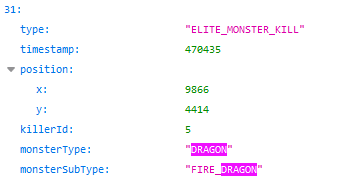

matchTimelineRequest.frames.event
event.type == "ELITE_MONSTER_KILL"
event.monsterType == "DRAGON" or "ELDER_DRAGON"

In [ ]:
obj_timeline_df = pd.DataFrame(match_obj)
elem_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] != 'ELDER_DRAGON'].dropna(axis=0).reset_index()



#store total# of drakes on each team, soul dragon info, and # of types of drakes for each team
for side in ['blue', 'red']:
    match_stats[side+'ElemDragNum'] = elem_drag_df[elem_drag_df['team'] == side].shape[0]
    if match_stats[side+'ElemDragNum'] == 4:
        match_stats['SoulType'] = elem_drag_df['DragElement'][2]
        match_stats['SoulTeam'] = side
    for drag_elem in list(elem_drag_df['DragElement'].unique()):
        match_stats[str(side+drag_elem)] = elem_drag_df.query('DragElement == @drag_elem and team == @side').shape[0]
        
#store all details about each drake for the game, including elder
drag_timeline_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index()
for row_idx, row in drag_timeline_df.iterrows():
    match_stats['drag'+str(row_idx+1)+'type'] = drag_timeline_df['DragElement'][row_idx]
    match_stats['drag'+str(row_idx+1)+'team'] = drag_timeline_df['team'][row_idx]
    match_stats['drag'+str(row_idx+1)+'time'] = drag_timeline_df['timestamp'][row_idx]

#store details about rift heralds and barons killed
for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
    #slice the df with the relevant objective
    obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()
    
    #for each herald/baron, extract the team that killed the objective and the time it occured
    for row_idx, row in obj_type_df.iterrows():
        match_stats[str(obj_type+str(row_idx+1)+'team')] = obj_type_df['team'][row_idx]
        match_stats[str(obj_type+str(row_idx+1)+'time')] = obj_type_df['timestamp'][row_idx]
    
        
        
    
    '''
for team in ['blue', 'red']:
    team_obj_df = obj_timeline_df[obj_timeline_df['team'] == team]
    team_obj_counts = team_obj_df['Objective Type'].value_counts()
    for obj_type in ['RIFTHERALD', 'DRAGON', 'BARON_NASHOR']:
        if team_obj_counts['Objective Type'].isin(obj_type):
            for n in range(team_obj_df[team_obj_df['Objective Type' == obj_type]].shape[0]):
                match_stats[str(obj_type+' '+n)] = 

for obj in obj_timeline_df.transpose():
    if obj_timeline_df['Objective Type'] == RIFTHERALD:
        match_stats['First Herald'] = 
    
    


In [ ]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [879]:
s = pd.Series()
s.astype(str) + (df['FIRE_DRAGONSoulteam'].replace(np.nan, '').astype(str))

3411673088    NaN
3435528193    NaN
3447586821    NaN
3426877449    NaN
3419144205    NaN
             ... 
3436877728    NaN
3422984098    NaN
3342243749    NaN
3448805286    NaN
3427833767    NaN
Length: 20000, dtype: object

In [867]:
df['FIRE_DRAGONSoulteam'].replace(np.nan, '').astype(str).add(df['WATER_DRAGONSoulteam'].replace(np.nan, '').astype(str), fill_value=None)

3411673088       
3435528193       
3447586821    red
3426877449       
3419144205       
             ... 
3436877728       
3422984098       
3342243749       
3448805286       
3427833767       
Length: 20000, dtype: object

In [711]:
len(match_stats_dict3)

20000

In [614]:
match_stats_dict

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'blue',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 1,
  'redriftHeraldKills': 0,
  'blueElemDragNum': 0,
  'blueFIRE_DRAGON': 0,
  'blueEARTH_DRAGON': 0,
  'redElemDragNum': 2,
  'redFIRE_DRAGON': 1,
  'redEARTH_DRAGON': 1,
  'drag1type': 'FIRE_DRAGON',
  'drag1team': 'red',
  'drag1time': 725786,
  'drag2type': 'EARTH_DRAGON',
  'drag2team': 'red',
  'drag2time': 1041620,
  'RIFTHERALD1team': 'blue',
  'RIFTHERALD1time': 587732},
 3435528193: {'GameDuration': 1516,
  'Winner': 'blue',
  'firstTower': 'blue',
  'firstInhibitor': 'red',
  'bluebaronKills': 0,
  'redbaronKills': 0,
  'blueriftHeraldKills': 0,
  'redriftHeraldKills': 0},
 3447586821: {'GameDuration': 1964,
  'Winner': 'blue',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstBaron': 'blue',
  'firstDragon': 'red',
  'bluebaronKills': 1,
  '

In [361]:
test_gameId = rand(matchlist)[0]
match_timeline = watcher.match.timeline_by_match(my_region, test_gameId)

In [362]:
test_gameId

3425793880

In [388]:
test_gameId = rand(matchlist)[0]
match_timeline = watcher.match.timeline_by_match(my_region, test_gameId)

match_obj = []
for i in range(len(match_timeline['frames'])):
    for event in match_timeline['frames'][i]['events']:
        #type == 'ELITE_MONSTER_KILL'
        if event['type'] == 'ELITE_MONSTER_KILL':
            obj = {}
            obj['ObjectiveType'] = event['monsterType']
            if event['monsterType'] == 'DRAGON':
                obj['DragElement'] = event['monsterSubType']
            obj['timestamp'] = event['timestamp']
            if 1<= event['killerId'] <= 5:
                obj['team'] = 'blue'
            elif 6<= event['killerId'] <= 10:
                obj['team'] = 'red'
            match_obj.append(obj)

#match_stats['obj'] = 
pd.DataFrame(match_obj)

,ObjectiveType,DragElement,timestamp,team
0,DRAGON,FIRE_DRAGON,372155,blue
1,DRAGON,WATER_DRAGON,694819,blue
2,RIFTHERALD,NaN,899295,red
3,DRAGON,AIR_DRAGON,1012964,blue
4,DRAGON,AIR_DRAGON,1353936,blue
5,DRAGON,ELDER_DRAGON,1824420,blue


In [389]:
obj_timeline_df = pd.DataFrame(match_obj)

In [390]:
obj_timeline_df

,ObjectiveType,DragElement,timestamp,team
0,DRAGON,FIRE_DRAGON,372155,blue
1,DRAGON,WATER_DRAGON,694819,blue
2,RIFTHERALD,NaN,899295,red
3,DRAGON,AIR_DRAGON,1012964,blue
4,DRAGON,AIR_DRAGON,1353936,blue
5,DRAGON,ELDER_DRAGON,1824420,blue


In [391]:
drag_timeline_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].reset_index()

In [392]:
drag_timeline_df

,index,ObjectiveType,DragElement,timestamp,team
0,0,DRAGON,FIRE_DRAGON,372155,blue
1,1,DRAGON,WATER_DRAGON,694819,blue
2,3,DRAGON,AIR_DRAGON,1012964,blue
3,4,DRAGON,AIR_DRAGON,1353936,blue
4,5,DRAGON,ELDER_DRAGON,1824420,blue


In [518]:
elem_drag_df

,index,ObjectiveType,DragElement,timestamp,team
0,0,DRAGON,FIRE_DRAGON,372155,blue
1,1,DRAGON,WATER_DRAGON,694819,blue
2,3,DRAGON,AIR_DRAGON,1012964,blue
3,4,DRAGON,AIR_DRAGON,1353936,blue


## LogisticRegression

In [650]:
from sklearn.linear_model import LogisticRegression

In [733]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [734]:
y_preds_logmodel = logmodel.predict(X_test)

In [735]:
classification_report(y_test, y_preds_logmodel, output_dict=True)

{'0': {'precision': 0.4694110920526015,
  'recall': 0.2881712881712882,
  'f1-score': 0.3571117877337973,
  'support': 2849},
 '1': {'precision': 0.5189753320683111,
  'recall': 0.7021822849807445,
  'f1-score': 0.5968357883251499,
  'support': 3116},
 'accuracy': 0.5044425817267393,
 'macro avg': {'precision': 0.4941932120604563,
  'recall': 0.4951767865760164,
  'f1-score': 0.47697378802947366,
  'support': 5965},
 'weighted avg': {'precision': 0.49530248717229153,
  'recall': 0.5044425817267393,
  'f1-score': 0.48233894378453573,
  'support': 5965}}

In [731]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, fbeta_score


In [667]:
clf = AdaBoostClassifier()

In [726]:
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [727]:
y_preds = clf.predict(X_test)

In [732]:
classification_report(y_test, y_preds, output_dict=True)

{'0': {'precision': 0.8914508691025186,
  'recall': 0.8820638820638821,
  'f1-score': 0.8867325335215244,
  'support': 2849},
 '1': {'precision': 0.8931977113795295,
  'recall': 0.9017971758664955,
  'f1-score': 0.8974768444586394,
  'support': 3116},
 'accuracy': 0.8923721709974853,
 'macro avg': {'precision': 0.892324290241024,
  'recall': 0.8919305289651889,
  'f1-score': 0.8921046889900819,
  'support': 5965},
 'weighted avg': {'precision': 0.8923633855375842,
  'recall': 0.8923721709974853,
  'f1-score': 0.8923451526128992,
  'support': 5965}}

In [745]:
clf_GB = GradientBoostingClassifier()
#GBC.decision_function(X_test)
clf_GB.fit(X_train, y_train)
y_preds_GB = clf_GB.predict(X_test)
classification_report(y_test, y_preds_GB, output_dict=True)

{'0': {'precision': 0.9026362038664323,
  'recall': 0.9013689013689014,
  'f1-score': 0.9020021074815595,
  'support': 2849},
 '1': {'precision': 0.9099358974358974,
  'recall': 0.9111039794608472,
  'f1-score': 0.9105195638229634,
  'support': 3116},
 'accuracy': 0.9064543168482816,
 'macro avg': {'precision': 0.9062860506511649,
  'recall': 0.9062364404148743,
  'f1-score': 0.9062608356522615,
  'support': 5965},
 'weighted avg': {'precision': 0.9064494218316381,
  'recall': 0.9064543168482816,
  'f1-score': 0.9064514610372703,
  'support': 5965}}

In [ ]:

imp=Imputer(missing_values="NaN", strategy="mean", axis=0)
linmodel = LinearModel()
steps=[('imputation',imp),('linear_regression',linmodel)]
pipeline=Pipeline(steps)
X_train, X_test, Y_train, Y_test=train_test_split(X, y, test_size=0.3, random_state=42)
pipeline.fit(X_train, Y_train)
y_pred=pipeline.predict(X_test)
pipeline.score(X_test, Y_test)

In [988]:
elder_drag_df[elder_drag_df['team'] == 'blue'].shape[0]

0

In [ ]:
match_stats['ELDER_DRAGONdiff'] = row['team']

In [775]:
var_soul

['FIRE_DRAGONSoulteam',
 'FIRE_DRAGONSoultime',
 'WATER_DRAGONSoulteam',
 'WATER_DRAGONSoultime',
 'AIR_DRAGONSoulteam',
 'AIR_DRAGONSoultime',
 'EARTH_DRAGONSoulteam',
 'EARTH_DRAGONSoultime']

In [782]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf_ada = AdaBoostClassifier(random_state = 42)

# Create the parameters list to tune
parameters = {'n_estimators':[10, 20, 60, 100], 'learning_rate': [0.05, 0.1, 0.2, 1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf_ada, param_grid = parameters, scoring = scorer, cv = 5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_ada.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8924
F-score on testing data: 0.8949

Optimized Model
------
Final accuracy score on the testing data: 0.9075
Final F-score on the testing data: 0.9116


In [ ]:
%%time
from sklearn.ensemble import VotingClassifier
#from random import randint
#try voting classifier
clf1 = GradientBoostingClassifier()
clf2 = AdaBoostClassifier()
vclf = VotingClassifier(estimators=[('gb', clf1), ('ada', clf2)], voting='hard')
params = {'ada__n_estimators':[10, 20, 60, 100], 
          'gb__n_estimators':[10, 20, 60, 100], 
          'ada__learning_rate': [0.05, 0.01, 0.1, 0.2, 1],
          'gb__learning_rate': [0.05, 0.01, 0.1, 0.2, 1],
         'gb__max_depth': [None, 1, 3, 5, 10]}

#{ 'rf__n_estimators': [20, 200],}
'''
{"max_depth": [3, None],
              "max_features": range(1, 9),
              "min_samples_leaf": range(1, 9),
              "criterion": ["gini", "entropy"]}

'''
random_search = RandomizedSearchCV(vclf, param_distributions=params,n_iter=4)
random_search.fit(X_train, y_train)
print(classification_report(y_test, random_search.predict(X_test)))